# Risk Management Assignment — Margining Simulation

**Goal:** Provide a *technically accurate*, *didactic*, and *pythonic* implementation of the assignment requirements:
- **(2a)** Derive **Initial Margin (IM)** theoretically (one-sided VaR over MPOR).
- **(2b)** Simulate **N spot price paths** for **252 trading days**.
- **(2c)** Simulate **defaults** under a **Baseline** (VM only) vs **Augmented** model (liquidity constraints + fire-sales).
- **(2d)** Produce the **dealer loss distribution** and interpret results.
- Evaluate **policy proposals (a–d)** and illustrate **procyclicality**.

This notebook is a self-contained solution that enforces consistency of assumptions, parameters, and notation from top to bottom.


## Block 1.1 — Economic Setup

**Institution A (Investor):** long Forward, mit begrenzter Liquidität (relevant für später).

**Institution B (Dealer):** jederzeit liquide, kein Default.

**Kontrakt:** Forward auf \(S\), Position \(Q\), Strike \(K\).

**MTM aus Sicht von A:**

\[
V_t = Q\,(S_t - K)
\]


## Block 1.2 — IM Herleitung

Annahme für die Preisänderung über \(\Delta\):

\[
`S_{t+\Delta} - S_t \sim \mathcal{N}(0,\,\Delta\,\sigma_s^2)`
\]

Da \(V_t = Q(S_t-K)\), folgt für die MTM-Änderung:

\[
V_{t+\Delta} - V_t = Q\,(S_{t+\Delta} - S_t)
\]

Also verteilt sich die MTM-Änderung als:

\[
V_{t+\Delta} - V_t \sim \mathcal{N}(0,\,Q^2\,\Delta\,\sigma_s^2)
\]

Standardabweichung über \(\Delta\):

\[
\sigma_{\Delta V} = |Q|\,\sigma_s\,\sqrt{\Delta}
\]

Initial Margin als one-sided \(\mathrm{VaR}_{0.99}\) über den MPOR:

\[
\mathrm{IM} = z_{0.99}\,|Q|\,\sigma_s\,\sqrt{\mathrm{MPOR}}
\]

mit

\[
z_{0.99} = \Phi^{-1}(0.99) \approx 2.326.
\]


## 1. Imports, Parameters, and Modeling Conventions

We keep a **single source of truth** for parameters in a `params` dictionary.  
All scenario/policy runs create **copies** of that dictionary (no hidden overwrites).

### Core Conventions
- **Underlying dynamics:** additive random walk (Bachelier-style)  
  \(S_{t+1} = S_t + \varepsilon_{t+1},\; \varepsilon_{t} \sim \mathcal N(0,\sigma_{daily}^2)\)
- **Forward MTM (from A’s perspective):** \(V_t = Q(S_t - K)\)
- **Variation Margin (VM):** on call dates, required collateral is \(\max(0,-V_t)\) (cash posted by A).
- **Exogenous default:** independent daily probability derived from annual PD via hazard-rate conversion.
- **Close-out:** on default day \(t\), close-out MTM is evaluated at \(t+\mathrm{MPOR}\).
- **Dealer loss:** \(\max(0, \text{owed at close-out} - (IM + VM_{t}) )\), extended appropriately when illiquid collateral is pledged.


In [1]:
# Imports
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import NormalDist
from typing import Dict, Any, Literal, Tuple
from IPython.display import display, Markdown

np.set_printoptions(suppress=True, precision=6)


In [2]:
# -----------------------------
# GLOBAL PARAMETERS (EDIT HERE)
# -----------------------------
params: Dict[str, Any] = {
    # Monte Carlo / horizon
    "N": 10_000,
    "T_sim": 252,          # trading days used for margining + exogenous default checks
    "T_maturity": 500,     # contractual maturity (days) — not binding here because T_sim < T_maturity
    "seed": 20260219,

    # Underlying / contract
    "S0": 100.0,
    "K": 100.0,            # forward strike
    "Q": 90.0,             # position size

    # Volatility (price units, additive model)
    "sigma_daily": 0.7,

    # Credit / margining
    "PD_annual": 0.15,     # annual exogenous default probability of A
    "MPOR": 8,             # margin period of risk (days)
    "VM_freq": 1,          # 1=daily, 5=weekly

    # Initial margin (VaR-based)
    "IM_conf": 0.99,
    "IM_mult": 1.0,        # policy lever (a): scale IM

    # Liquidity / fire-sales (Augmented model)
    "L0": 350.0,           # cash available for VM *net of baseline IM* (see 'L_total' below for IM-funded runs)
    "A0": 1200.0,          # market value of illiquid assets at t=0
    "h": 0.22,             # baseline fire-sale haircut

    # Section 1.5: procyclicality (endogenous haircuts)
    "systemic_M": 500,     # number of investors in the systemic (multi-investor) experiment
    "h_max": 0.65,         # cap on endogenous haircut
    "gamma_h": 0.50,       # haircut sensitivity to aggregate sales share in previous period

    # Modeling conventions
    # - "after_vm": exogenous default is checked after VM settlement at day t (optimistic)
    # - "before_vm": exogenous default is checked before VM settlement at day t (conservative)
    "default_timing": "after_vm",

    # If True: IM is funded from a fixed liquidity budget L_total (see below).
    # If False: interpret L0 as cash available for VM *net of IM* (IM does not reduce L0).
    "im_posted_from_cash": False,
}

pd.DataFrame([params]).T.rename(columns={0: "value"})


,value
N,10000
T_sim,252
T_maturity,500
seed,20260219
S0,100.0
K,100.0
Q,90.0
sigma_daily,0.7
PD_annual,0.15
MPOR,8


### Liquidity convention (why L0 can be smaller than IM)

In the augmented model party **A** has limited cash and may need to raise liquidity via fire-sales.  
The notebook supports **two equivalent accounting conventions** for the initial liquidity budget:

1) `im_posted_from_cash = False` (**default**): we interpret **L0 as VM-cash *net of* baseline IM**.  
   IM is treated as already segregated/posted at `t=0` and therefore **does not reduce** the VM-cash shown as `L0`.  
   Under this convention the *total* initial liquidity resources are implicitly  
   `L_total = L0 + IM` (for the baseline IM level).

2) `im_posted_from_cash = True`: we fix a **total cash budget** `L_total` and **explicitly deduct IM at t=0**, so VM-cash starts at  
   `cash_0 = L_total - IM`.

**Important:** In the base case `L0 = 350 < IM ≈ 414.53` does **not** mean A cannot post IM.  
It means we are reporting the **remaining VM-cash after posting IM** (net-of-IM convention).  
For policies that change IM (Policy **a** and **c**) we additionally show the economically meaningful “IM funded from a fixed cash budget” variant (`im_posted_from_cash = True`).

### Parameter rationale and model limitations (report-ready)

- **MPOR = 8 days**: the assignment suggests 10 days; we choose 8 as a plausible MPOR **within the typical 5–10 day range**.  
  (Qualitative conclusions are unchanged; Policy **c** explores shorter MPOR.)
- **PD_annual = 15%**: intentionally **stressed counterparty** (high-yield-like) so that Monte Carlo tail metrics are statistically stable with `N=10,000`.
- **default_timing = "after_vm"**: optimistic convention (VM is settled before checking exogenous default).  
  A sensitivity for `"before_vm"` is provided in Section 11.
- **Additive random walk (Bachelier)**: because price changes are Normal and additive, `S_t` can become negative.  
  This is consistent with the assignment’s additive-normal setup, but economically it should be interpreted as a **price/spread index** rather than a strictly positive equity price.


## 2. Helper Functions (pythonic, single-purpose)

In [3]:

def annual_pd_to_daily(PD_annual: float, days: int = 252) -> float:
    # Convert annual default probability to daily default probability using a constant hazard rate:
    #   lambda = -ln(1 - PD_annual)
    #   p_day = 1 - exp(-lambda/days)
    PD_annual = float(PD_annual)
    if not (0.0 <= PD_annual < 1.0):
        raise ValueError("PD_annual must be in [0,1).")
    lam = -np.log(1.0 - PD_annual)
    return float(1.0 - np.exp(-lam / float(days)))


def compute_im(Q: float, sigma_daily: float, MPOR: int, conf: float = 0.99, mult: float = 1.0) -> Tuple[float, float]:
    # Initial Margin as one-sided VaR over MPOR under additive normal price changes:
    #   IM = z_conf * |Q| * sigma_daily * sqrt(MPOR)
    z = NormalDist().inv_cdf(float(conf))
    IM = float(mult) * float(z) * abs(float(Q)) * float(sigma_daily) * float(np.sqrt(int(MPOR)))
    return IM, float(z)


def simulate_market_paths(params: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray]:
    # Simulate additive price paths up to T_full = T_sim + MPOR so that close-out V_{t+MPOR}
    # is always available without extra simulation.
    N = int(params["N"])
    T_sim = int(params["T_sim"])
    MPOR = int(params["MPOR"])
    T_full = T_sim + MPOR

    S0 = float(params["S0"])
    sigma = float(params["sigma_daily"])
    seed = int(params["seed"])

    rng = np.random.default_rng(seed)
    dS = rng.normal(loc=0.0, scale=sigma, size=(N, T_full))  # increments for t=1..T_full

    S = np.empty((N, T_full + 1), dtype=float)
    S[:, 0] = S0
    S[:, 1:] = S0 + np.cumsum(dS, axis=1)

    Q = float(params["Q"])
    K = float(params["K"])
    V = Q * (S - K)
    return S, V


def generate_exogenous_uniforms(params: Dict[str, Any]) -> np.ndarray:
    # U ~ Uniform(0,1) draws for exogenous default decisions: shape (N, T_sim) for t=1..T_sim.
    N = int(params["N"])
    T_sim = int(params["T_sim"])
    seed = int(params["seed"]) + 999
    rng = np.random.default_rng(seed)
    return rng.random((N, T_sim))


## 3. Market Simulation (Task 2b)

S_paths shape: (10000, 261)
V_paths shape: (10000, 261)


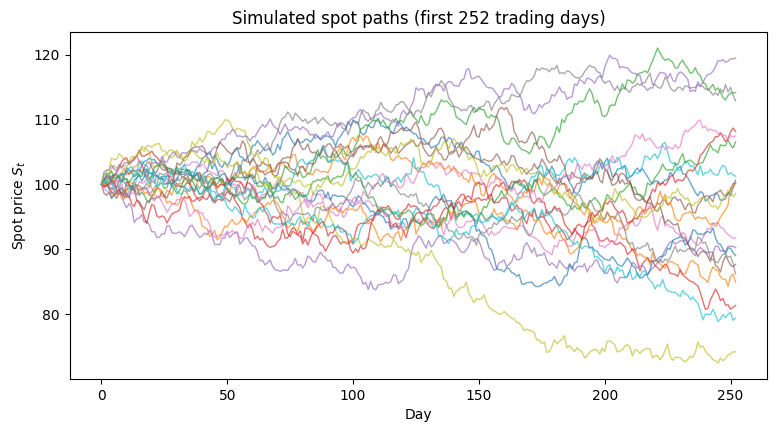

In [4]:
S_paths, V_paths = simulate_market_paths(params)
U_exog = generate_exogenous_uniforms(params)

print("S_paths shape:", S_paths.shape)
print("V_paths shape:", V_paths.shape)

# Quick diagnostic plot: a few spot paths (first 252 days)
rng_vis = np.random.default_rng(params["seed"] + 123)
idx = rng_vis.choice(params["N"], size=min(20, params["N"]), replace=False)

fig, ax = plt.subplots(figsize=(9, 4.5))
for i in idx:
    ax.plot(S_paths[i, : params["T_sim"] + 1], alpha=0.65, linewidth=1.0)
ax.set_title("Simulated spot paths (first 252 trading days)")
ax.set_xlabel("Day")
ax.set_ylabel("Spot price $S_t$")
plt.show()


## 4. Default Model and Initial Margin Level (Task 2a + inputs to 2c/2d)

In [5]:
p_day = annual_pd_to_daily(params["PD_annual"], days=params["T_sim"])
IM_base, z_conf = compute_im(
    Q=params["Q"],
    sigma_daily=params["sigma_daily"],
    MPOR=params["MPOR"],
    conf=params["IM_conf"],
    mult=params["IM_mult"],
)

print(f"Daily exogenous default probability p_day = {p_day:.8f}")
print(f"z_{params['IM_conf']:.2f} = {z_conf:.6f}")
print(f"Baseline IM = {IM_base:.6f}")


Daily exogenous default probability p_day = 0.00064471
z_0.99 = 2.326348
Baseline IM = 414.534042


## 5. Baseline Margining Engine (Task 2c baseline)

In [6]:
def run_baseline_exogenous(
    V: np.ndarray,
    IM: float,
    MPOR: int,
    p_day: float,
    VM_freq: int,
    U_exog: np.ndarray,
    default_timing: Literal["before_vm", "after_vm"] = "after_vm",
    T_sim: int = 252,
) -> pd.DataFrame:
    """Baseline: symmetric VM (both parties) with unlimited liquidity.

    Convention: V_t is MTM to party A. Therefore
      - if V_t < 0: A is out-of-the-money and posts VM to B: VM_A_to_B = -V_t
      - if V_t > 0: B posts VM to A: VM_B_to_A =  V_t

    VM balances are reset to required amounts whenever there is a margin call (every VM_freq days).
    Losses are reported for party B in the event of A default; thus only collateral held by B
    (IM + VM_A_to_B) is credited when computing B's loss.
    """
    if default_timing not in ("before_vm", "after_vm"):
        raise ValueError("default_timing must be 'before_vm' or 'after_vm'.")

    N = V.shape[0]
    losses = np.zeros(N, dtype=float)
    default_flag = np.zeros(N, dtype=bool)
    default_day = np.full(N, -1, dtype=int)

    vm_A_to_B = np.zeros(N, dtype=float)   # collateral posted by A to B (held by B)
    vm_B_to_A = np.zeros(N, dtype=float)   # collateral posted by B to A (held by A)

    max_call_A = np.zeros(N, dtype=float)  # max *positive* margin call paid by A (A->B)
    max_call_B = np.zeros(N, dtype=float)  # max *positive* margin call paid by B (B->A)

    for i in range(N):
        vmA = 0.0
        vmB = 0.0
        reqA_prev = 0.0
        reqB_prev = 0.0

        for t in range(1, int(T_sim) + 1):
            u = float(U_exog[i, t - 1])

            # Default event before VM update
            if default_timing == "before_vm" and u < float(p_day):
                default_flag[i] = True
                default_day[i] = t
                close_t = t + int(MPOR)
                owed = max(-float(V[i, close_t]), 0.0)  # amount owed to B at close-out
                losses[i] = max(owed - (float(IM) + vmA), 0.0)
                break

            # VM reset / margin call
            if (t % int(VM_freq)) == 0:
                reqA = max(0.0, -float(V[i, t]))  # A posts if A is OTM (V<0)
                reqB = max(0.0,  float(V[i, t]))  # B posts if B is OTM (V>0)

                callA = reqA - reqA_prev
                callB = reqB - reqB_prev

                if callA > max_call_A[i]:
                    max_call_A[i] = callA
                if callB > max_call_B[i]:
                    max_call_B[i] = callB

                vmA = reqA
                vmB = reqB
                reqA_prev = reqA
                reqB_prev = reqB

            # Default event after VM update
            if default_timing == "after_vm" and u < float(p_day):
                default_flag[i] = True
                default_day[i] = t
                close_t = t + int(MPOR)
                owed = max(-float(V[i, close_t]), 0.0)
                losses[i] = max(owed - (float(IM) + vmA), 0.0)
                break

        vm_A_to_B[i] = vmA
        vm_B_to_A[i] = vmB

    df = pd.DataFrame({
        "loss_B": losses,
        "default_flag": default_flag,
        "default_day": default_day,
        "default_type": np.where(default_flag, "exogenous", "none"),

        # VM accounts (symmetric)
        "vm_A_to_B": vm_A_to_B,
        "vm_B_to_A": vm_B_to_A,

        # Backward-compatible aliases (legacy columns)
        "vm_account": vm_A_to_B,

        "max_margin_call_A": max_call_A,
        "max_margin_call_B": max_call_B,
        "max_margin_call": max_call_A,  # legacy: max call faced by A (A->B)

        "fire_sale_cost": 0.0,
        "fire_sale_events": 0,
    })
    return df


## 6. Augmented Model: Liquidity Constraints & Fire-Sales (Task 2c augmented)

In [7]:
def run_augmented_liquidity(
    V: np.ndarray,
    IM: float,
    MPOR: int,
    p_day: float,
    VM_freq: int,
    L0: float,
    A0: float,
    h: float,
    U_exog: np.ndarray,
    default_timing: Literal["before_vm", "after_vm"] = "after_vm",
    im_posted_from_cash: bool = False,
    T_sim: int = 252,
) -> pd.DataFrame:
    """Augmented setting: symmetric VM (both parties) + liquidity constraints + fire-sales.

    Convention: V_t is MTM to party A.
      - A posts VM to B when V_t < 0  (A is OTM):  VM_A_to_B = -V_t
      - B posts VM to A when V_t > 0  (B is OTM):  VM_B_to_A =  V_t

    Party B is assumed always liquid (can always post/return VM). Party A has limited cash L0 and
    can raise cash by selling an illiquid asset with haircut h. If A cannot meet a required cash
    outflow (posting VM or returning received VM), A defaults for liquidity reasons.

    Losses are reported for party B in the event of A default; thus only collateral held by B
    (IM + VM_A_to_B) is credited when computing B's loss.
    """
    if default_timing not in ("before_vm", "after_vm"):
        raise ValueError("default_timing must be 'before_vm' or 'after_vm'.")

    N = V.shape[0]

    losses = np.zeros(N, dtype=float)
    default_flag = np.zeros(N, dtype=bool)
    default_day = np.full(N, -1, dtype=int)
    default_type = np.full(N, "none", dtype=object)

    fire_sale_cost = np.zeros(N, dtype=float)
    fire_sale_events = np.zeros(N, dtype=int)

    last_VM_A_to_B = np.zeros(N, dtype=float)
    last_VM_B_to_A = np.zeros(N, dtype=float)

    cash_end = np.zeros(N, dtype=float)
    illiquid_end = np.zeros(N, dtype=float)

    def _fund_outflow(cash: float, illiquid_value: float, need: float) -> Tuple[float, float, float, int, float]:
        """Try to fund a cash outflow 'need' using cash first, then fire-sale illiquid asset.

        Returns: updated cash, illiquid_value, incremental_fire_cost, incremental_fire_events, remaining_need
        """
        inc_cost = 0.0
        inc_events = 0

        pay = min(cash, need)
        cash -= pay
        need -= pay

        if need > 1e-12 and illiquid_value > 0.0:
            sell_mv = min(illiquid_value, need / (1.0 - float(h)))
            proceeds = sell_mv * (1.0 - float(h))
            illiquid_value -= sell_mv
            cash += proceeds

            if sell_mv > 0.0:
                inc_cost += sell_mv * float(h)
                inc_events += 1

            pay2 = min(cash, need)
            cash -= pay2
            need -= pay2

        return cash, illiquid_value, inc_cost, inc_events, need

    for i in range(N):
        # Cash budget: optionally treat IM as funded from cash
        cash = float(L0) - float(IM) if bool(im_posted_from_cash) else float(L0)
        illiquid_value = float(A0)

        vmA = 0.0  # posted by A to B (held by B)
        vmB = 0.0  # posted by B to A (held by A)
        defaulted = False

        # Immediate liquidity default if IM is funded from cash and pushes cash negative
        if cash < 0.0:
            defaulted = True
            default_flag[i] = True
            default_type[i] = "liquidity"
            default_day[i] = 0
            last_VM_A_to_B[i] = vmA
            last_VM_B_to_A[i] = vmB

        for t in range(1, int(T_sim) + 1):
            if defaulted:
                break

            u = float(U_exog[i, t - 1])

            # Exogenous default before VM update
            if default_timing == "before_vm" and u < float(p_day):
                defaulted = True
                default_flag[i] = True
                default_type[i] = "exogenous"
                default_day[i] = t
                last_VM_A_to_B[i] = vmA
                last_VM_B_to_A[i] = vmB
                break

            if (t % int(VM_freq)) == 0:
                reqA = max(0.0, -float(V[i, t]))  # A must post to B if V<0
                reqB = max(0.0,  float(V[i, t]))  # B must post to A if V>0

                # ---- Adjust A->B VM (cash outflow if increases, inflow if decreases)
                deltaA = reqA - vmA
                if deltaA > 1e-12:
                    cash, illiquid_value, c, e, rem = _fund_outflow(cash, illiquid_value, float(deltaA))
                    fire_sale_cost[i] += c
                    fire_sale_events[i] += e
                    if rem > 1e-6:
                        defaulted = True
                        default_flag[i] = True
                        default_type[i] = "liquidity"
                        default_day[i] = t
                        # vmA reflects what was actually posted up to default
                        vmA = reqA - rem
                    else:
                        vmA = reqA
                elif deltaA < -1e-12:
                    # collateral released back to A
                    cash += (-deltaA)
                    vmA = reqA
                else:
                    vmA = reqA

                if defaulted:
                    last_VM_A_to_B[i] = vmA
                    last_VM_B_to_A[i] = vmB
                    break

                # ---- Adjust B->A VM (cash inflow if increases, outflow if decreases/return)
                deltaB = reqB - vmB
                if deltaB > 1e-12:
                    # B posts additional VM to A -> A receives cash
                    cash += float(deltaB)
                    vmB = reqB
                elif deltaB < -1e-12:
                    # A must return cash to B
                    outflow = float(-deltaB)
                    cash, illiquid_value, c, e, rem = _fund_outflow(cash, illiquid_value, outflow)
                    fire_sale_cost[i] += c
                    fire_sale_events[i] += e
                    if rem > 1e-6:
                        defaulted = True
                        default_flag[i] = True
                        default_type[i] = "liquidity"
                        default_day[i] = t
                        # vmB reflects what remains held by A at default
                        vmB = reqB + rem
                    else:
                        vmB = reqB
                else:
                    vmB = reqB

                last_VM_A_to_B[i] = vmA
                last_VM_B_to_A[i] = vmB

            # Exogenous default after VM update
            if default_timing == "after_vm" and u < float(p_day):
                defaulted = True
                default_flag[i] = True
                default_type[i] = "exogenous"
                default_day[i] = t
                last_VM_A_to_B[i] = vmA
                last_VM_B_to_A[i] = vmB
                break

        if defaulted:
            t_def = int(default_day[i])
            close_t = t_def + int(MPOR)
            owed = max(-float(V[i, close_t]), 0.0)
            collateral_available = float(IM) + max(float(last_VM_A_to_B[i]), 0.0)
            losses[i] = max(owed - collateral_available, 0.0)

        cash_end[i] = cash
        illiquid_end[i] = illiquid_value

    df = pd.DataFrame({
        "loss_B": losses,
        "default_flag": default_flag,
        "default_type": default_type,
        "default_day": default_day,

        "fire_sale_cost": fire_sale_cost,
        "fire_sale_events": fire_sale_events,

        # VM accounts (symmetric)
        "vm_A_to_B": last_VM_A_to_B,
        "vm_B_to_A": last_VM_B_to_A,

        # Backward-compatible aliases
        "last_VM_posted": last_VM_A_to_B,  # legacy name: VM posted by A (to B)
        "last_VM_received": last_VM_B_to_A,

        "cash_end": cash_end,
        "illiquid_end": illiquid_end,
    })
    return df


## 7. Policy (d) Expanded Collateral Set — Additional Engine

In [8]:

def simulate_illiquid_paths(params: Dict[str, Any], sigma_factor: float = 1.0, seed_offset: int = 2021) -> np.ndarray:
    # Illiquid asset market value (Policy d): additive RW with volatility sigma_factor * sigma_daily, floored at 0.
    N = int(params["N"])
    T_sim = int(params["T_sim"])
    MPOR = int(params["MPOR"])
    T_full = T_sim + MPOR

    A0 = float(params["A0"])
    sigma = float(params["sigma_daily"]) * float(sigma_factor)
    seed = int(params["seed"]) + int(seed_offset)

    rng = np.random.default_rng(seed)
    dI = rng.normal(loc=0.0, scale=sigma, size=(N, T_full))

    Ill = np.empty((N, T_full + 1), dtype=float)
    Ill[:, 0] = A0
    Ill[:, 1:] = A0 + np.cumsum(dI, axis=1)
    Ill[Ill < 0] = 0.0
    return Ill


def run_augmented_collateral_expanded(
    V: np.ndarray,
    Ill: np.ndarray,
    IM: float,
    MPOR: int,
    p_day: float,
    VM_freq: int,
    L0: float,
    h_sale: float,
    eligible_share: float = 0.75,
    h_collat: float | None = None,
    U_exog: np.ndarray | None = None,
    default_timing: Literal["before_vm", "after_vm"] = "after_vm",
    im_posted_from_cash: bool = False,
    T_sim: int = 252,
) -> pd.DataFrame:
    # Policy (d): A can pledge eligible_share of illiquid holdings as collateral (haircut h_collat), reducing fire-sales.
    if U_exog is None:
        raise ValueError("U_exog must be provided for consistent comparisons.")
    if default_timing not in ("before_vm", "after_vm"):
        raise ValueError("default_timing must be 'before_vm' or 'after_vm'.")
    if not (0.0 <= float(eligible_share) <= 1.0):
        raise ValueError("eligible_share must be in [0,1].")

    h_collat = float(h_sale if h_collat is None else h_collat)

    N = V.shape[0]

    losses = np.zeros(N, dtype=float)
    default_flag = np.zeros(N, dtype=bool)
    default_day = np.full(N, -1, dtype=int)
    default_type = np.full(N, "none", dtype=object)

    fire_sale_cost = np.zeros(N, dtype=float)
    fire_sale_events = np.zeros(N, dtype=int)
    last_VM_posted = np.zeros(N, dtype=float)

    pledged_frac_end = np.zeros(N, dtype=float)
    hold_frac_end = np.zeros(N, dtype=float)
    vm_cash_end = np.zeros(N, dtype=float)
    cash_end = np.zeros(N, dtype=float)

    for i in range(N):
        cash = float(L0) - float(IM) if bool(im_posted_from_cash) else float(L0)

        vm_cash = 0.0
        pledged_frac = 0.0
        hold_frac = 1.0
        required_prev = 0.0
        defaulted = False

        if cash < 0:
            defaulted = True
            default_flag[i] = True
            default_type[i] = "liquidity"
            default_day[i] = 0

        for t in range(1, int(T_sim) + 1):
            if defaulted:
                break

            u = float(U_exog[i, t - 1])

            if default_timing == "before_vm" and u < float(p_day):
                defaulted = True
                default_flag[i] = True
                default_type[i] = "exogenous"
                default_day[i] = t
                break

            if (t % int(VM_freq)) == 0:
                required = max(0.0, -float(V[i, t]))
                # effective collateral = cash-collateral + haircut-adjusted pledged illiquid
                pledged_value = float(Ill[i, t]) * pledged_frac
                ill_credit = (1.0 - h_collat) * pledged_value

                current_effective = vm_cash + ill_credit
                target_effective = required

                if target_effective > current_effective + 1e-12:
                    shortfall = target_effective - current_effective

                    pay = min(cash, shortfall)
                    cash -= pay
                    vm_cash += pay
                    shortfall -= pay

                    if shortfall > 1e-12:
                        max_pledge_frac = min(float(eligible_share), hold_frac)
                        add_pledge_frac = max_pledge_frac - pledged_frac
                        if add_pledge_frac > 1e-12 and float(Ill[i, t]) > 0:
                            needed_mv = shortfall / (1.0 - h_collat)
                            available_mv = float(Ill[i, t]) * add_pledge_frac
                            pledge_mv = min(available_mv, needed_mv)

                            pledged_frac += pledge_mv / float(Ill[i, t])
                            pledged_frac = min(pledged_frac, max_pledge_frac)

                            pledged_value = float(Ill[i, t]) * pledged_frac
                            ill_credit = (1.0 - h_collat) * pledged_value
                            current_effective = vm_cash + ill_credit
                            shortfall = max(target_effective - current_effective, 0.0)

                    if shortfall > 1e-12 and hold_frac > pledged_frac and float(Ill[i, t]) > 0:
                        unpledged_frac = hold_frac - pledged_frac
                        unpledged_mv = float(Ill[i, t]) * unpledged_frac

                        sell_mv = min(unpledged_mv, shortfall / (1.0 - float(h_sale)))
                        proceeds = sell_mv * (1.0 - float(h_sale))
                        sold_frac = sell_mv / float(Ill[i, t])
                        hold_frac = max(hold_frac - sold_frac, 0.0)

                        cash += proceeds
                        if sell_mv > 0:
                            fire_sale_cost[i] += sell_mv * float(h_sale)
                            fire_sale_events[i] += 1

                        pay2 = min(cash, shortfall)
                        cash -= pay2
                        vm_cash += pay2
                        shortfall -= pay2

                    if shortfall > 1e-6:
                        defaulted = True
                        default_flag[i] = True
                        default_type[i] = "liquidity"
                        default_day[i] = t
                        break

                elif target_effective < current_effective - 1e-12:
                    release = current_effective - target_effective
                    release_cash = min(vm_cash, release)
                    vm_cash -= release_cash
                    cash += release_cash
                    release -= release_cash

                    if release > 1e-12 and pledged_frac > 0 and float(Ill[i, t]) > 0:
                        reduce_mv = release / (1.0 - h_collat)
                        pledged_value = float(Ill[i, t]) * pledged_frac
                        reduce_mv = min(reduce_mv, pledged_value)
                        pledged_frac -= reduce_mv / float(Ill[i, t])
                        pledged_frac = max(pledged_frac, 0.0)

                required_prev = required
                last_VM_posted[i] = required

            if default_timing == "after_vm" and u < float(p_day):
                defaulted = True
                default_flag[i] = True
                default_type[i] = "exogenous"
                default_day[i] = t
                break

        if defaulted:
            t_def = int(default_day[i])
            close_t = t_def + int(MPOR)
            owed = max(-float(V[i, close_t]), 0.0)

            pledged_value_close = float(Ill[i, close_t]) * pledged_frac
            ill_credit_close = (1.0 - h_collat) * pledged_value_close

            collateral_available = float(IM) + vm_cash + ill_credit_close
            losses[i] = max(owed - collateral_available, 0.0)

        pledged_frac_end[i] = pledged_frac
        hold_frac_end[i] = hold_frac
        vm_cash_end[i] = vm_cash
        cash_end[i] = cash

    df = pd.DataFrame({
        "loss_B": losses,
        "default_flag": default_flag,
        "default_type": default_type,
        "default_day": default_day,
        "fire_sale_cost": fire_sale_cost,
        "fire_sale_events": fire_sale_events,
        "last_VM_posted": last_VM_posted,
        "pledged_frac_end": pledged_frac_end,
        "hold_frac_end": hold_frac_end,
        "vm_cash_end": vm_cash_end,
        "cash_end": cash_end,
    })
    return df


## 8. Run Baseline vs Augmented (Tasks 2c & 2d)

In [9]:
base_df = run_baseline_exogenous(
    V=V_paths,
    IM=IM_base,
    MPOR=params["MPOR"],
    p_day=p_day,
    VM_freq=params["VM_freq"],
    U_exog=U_exog,
    default_timing=params["default_timing"],
    T_sim=params["T_sim"],
)

aug_df = run_augmented_liquidity(
    V=V_paths,
    IM=IM_base,
    MPOR=params["MPOR"],
    p_day=p_day,
    VM_freq=params["VM_freq"],
    L0=params["L0"],
    A0=params["A0"],
    h=params["h"],
    U_exog=U_exog,
    default_timing=params["default_timing"],
    im_posted_from_cash=params["im_posted_from_cash"],
    T_sim=params["T_sim"],
)

display(base_df.head())
display(aug_df.head())

print("Baseline default rate:", base_df["default_flag"].mean())
print("Augmented default rate:", aug_df["default_flag"].mean())
print("Augmented liquidity default rate:", (aug_df["default_type"] == "liquidity").mean())


,loss_B,default_flag,default_day,default_type,vm_A_to_B,vm_B_to_A,vm_account,max_margin_call_A,max_margin_call_B,max_margin_call,fire_sale_cost,fire_sale_events
0,0.0,False,-1,none,0.000000,1787.408350,0.000000,0.000000,202.831773,0.000000,0.0,0
1,0.0,False,-1,none,542.555607,0.000000,542.555607,153.042494,127.163429,153.042494,0.0,0
2,0.0,False,-1,none,125.793883,0.000000,125.793883,176.465832,155.908995,176.465832,0.0,0
3,0.0,True,105,exogenous,0.000000,499.360933,0.000000,101.296894,154.885396,101.296894,0.0,0
4,0.0,False,-1,none,0.000000,654.797821,0.000000,135.387453,166.105971,135.387453,0.0,0


,loss_B,default_flag,default_type,default_day,fire_sale_cost,fire_sale_events,vm_A_to_B,vm_B_to_A,last_VM_posted,last_VM_received,cash_end,illiquid_end
0,0.0,False,none,-1,0.000000,0,0.000000,1787.408350,0.000000,1787.408350,2137.408350,1200.000000
1,0.0,False,none,-1,92.795965,13,542.555607,0.000000,542.555607,0.000000,136.448267,778.200161
2,0.0,False,none,-1,0.000000,0,125.793883,0.000000,125.793883,0.000000,224.206117,1200.000000
3,0.0,True,exogenous,105,0.000000,0,0.000000,499.360933,0.000000,499.360933,849.360933,1200.000000
4,0.0,False,none,-1,0.000000,0,0.000000,654.797821,0.000000,654.797821,1004.797821,1200.000000


Baseline default rate: 0.1511
Augmented default rate: 0.3052
Augmented liquidity default rate: 0.1644


## 9. Loss Distribution Metrics (EL, VaR, ES)

In [10]:
def _tail_es(x: np.ndarray, q: float) -> float:
    tail = x[x >= q]
    return float(np.mean(tail)) if tail.size > 0 else float(q)


def risk_metrics(losses, alpha: float = 0.99) -> Dict[str, float]:
    """Unconditional risk metrics + conditional (loss>0) metrics.

    Note: When the loss distribution has a large point mass at 0, VaR(alpha) can be 0.
    The conditional metrics (given loss>0) are therefore reported explicitly.
    """
    x = np.asarray(losses, dtype=float)

    EL = float(np.mean(x))
    VaR = float(np.quantile(x, alpha))
    ES = _tail_es(x, VaR)

    pos = x[x > 0]
    P_pos = float(pos.size / x.size)
    EL_pos = float(np.mean(pos)) if pos.size > 0 else 0.0
    VaR_pos = float(np.quantile(pos, alpha)) if pos.size > 0 else 0.0
    ES_pos = _tail_es(pos, VaR_pos) if pos.size > 0 else 0.0

    return {
        "EL": EL, "VaR": VaR, "ES": ES,
        "P_loss_pos": P_pos,
        "EL_pos": EL_pos, "VaR_pos": VaR_pos, "ES_pos": ES_pos,
        "max_loss": float(np.max(x)) if x.size else 0.0,
    }


def risk_metrics_masked(losses, mask: np.ndarray, alpha: float = 0.99) -> Dict[str, float]:
    mask = np.asarray(mask, dtype=bool)
    x = np.asarray(losses, dtype=float)[mask]
    if x.size == 0:
        return {"n": 0, "EL": 0.0, "VaR": 0.0, "ES": 0.0, "P_loss_pos": 0.0, "EL_pos": 0.0, "VaR_pos": 0.0, "ES_pos": 0.0, "max_loss": 0.0}
    out = risk_metrics(x, alpha=alpha)
    out["n"] = int(x.size)
    return out


def scenario_bundle(df: pd.DataFrame, alpha: float = 0.99) -> Dict[str, float]:
    loss = np.asarray(df["loss_B"], dtype=float)
    out = risk_metrics(loss, alpha=alpha)

    out["P_default"] = float(df["default_flag"].mean())
    if "default_type" in df.columns:
        out["P_liq_default"] = float((df["default_type"] == "liquidity").mean())
    else:
        out["P_liq_default"] = 0.0

    out["E_fire_cost"] = float(df["fire_sale_cost"].mean()) if "fire_sale_cost" in df.columns else 0.0
    out["E_fire_events"] = float(df["fire_sale_events"].mean()) if "fire_sale_events" in df.columns else 0.0

    # Conditional on default (often the economically relevant tail state)
    out_def = risk_metrics_masked(loss, np.asarray(df["default_flag"].values, dtype=bool), alpha=alpha)
    out["EL_given_default"] = out_def["EL"]
    out["VaR_given_default"] = out_def["VaR"]
    out["ES_given_default"] = out_def["ES"]
    out["P_loss_pos_given_default"] = out_def["P_loss_pos"]
    out["EL_pos_given_default"] = out_def["EL_pos"]

    return out


metrics_base_99 = scenario_bundle(base_df, alpha=0.99)
metrics_aug_99  = scenario_bundle(aug_df,  alpha=0.99)

summary_core = pd.DataFrame([
    {"scenario": "Baseline", **metrics_base_99},
    {"scenario": "Augmented", **metrics_aug_99},
])

# Make a compact view for report tables
keep_cols = [
    "scenario",
    "P_default", "P_liq_default",
    "EL", "VaR", "ES",
    "P_loss_pos", "EL_pos", "VaR_pos", "ES_pos",
    "E_fire_cost", "E_fire_events",
    "EL_given_default", "P_loss_pos_given_default", "EL_pos_given_default",
    "max_loss",
]
core_view = summary_core[keep_cols].copy()

# --- Report-friendly formatting (explicit α and probability units)
alpha_core = 0.99
alpha_tag = int(round(alpha_core * 100))

core_view_fmt = core_view.copy()

# Probabilities -> percent
prob_cols = ["P_default", "P_liq_default", "P_loss_pos", "P_loss_pos_given_default"]
for c in prob_cols:
    if c in core_view_fmt.columns:
        core_view_fmt[c] = (100 * core_view_fmt[c]).round(2)

# Round loss / exposure metrics
num6 = ["EL", "VaR", "ES", "EL_pos", "VaR_pos", "ES_pos", "E_fire_cost", "max_loss", "EL_given_default", "VaR_given_default", "ES_given_default"]
for c in num6:
    if c in core_view_fmt.columns:
        core_view_fmt[c] = core_view_fmt[c].round(6)

for c in ["E_fire_events", "EL_pos_given_default"]:
    if c in core_view_fmt.columns:
        core_view_fmt[c] = core_view_fmt[c].round(4)

# Rename to make α explicit and mark percent columns
rename_map = {
    "VaR": f"VaR{alpha_tag}",
    "ES": f"ES{alpha_tag}",
    "VaR_pos": f"VaR{alpha_tag}_pos",
    "ES_pos": f"ES{alpha_tag}_pos",
    "VaR_given_default": f"VaR{alpha_tag}_given_default",
    "ES_given_default": f"ES{alpha_tag}_given_default",
    "P_default": "P_default (%)",
    "P_liq_default": "P_liq_default (%)",
    "P_loss_pos": "P_loss_pos (%)",
    "P_loss_pos_given_default": "P_loss_pos_given_default (%)",
}
core_view_fmt = core_view_fmt.rename(columns=rename_map)

display(core_view_fmt)

print(f"Note: All VaR/ES are computed at α={alpha_core:.2f}. If VaR{alpha_tag} is 0, interpret conditional metrics (given loss>0) as the meaningful tail summary.")


,scenario,P_default (%),P_liq_default (%),EL,VaR99,ES99,P_loss_pos (%),EL_pos,VaR99_pos,ES99_pos,E_fire_cost,E_fire_events,EL_given_default,P_loss_pos_given_default (%),EL_pos_given_default,max_loss
0,Baseline,15.11,0.00,0.008488,0.0,0.008488,0.01,84.876648,84.876648,84.876648,0.000000,0.0000,0.056173,0.07,84.8766,84.876648
1,Augmented,30.52,16.44,0.264181,0.0,0.264181,0.31,85.219557,274.874303,292.913975,100.448185,8.1439,0.865598,1.02,85.2196,292.913975


Note: All VaR/ES are computed at α=0.99. If VaR99 is 0, interpret conditional metrics (given loss>0) as the meaningful tail summary.


## 10. Plots: Loss Distributions and Fire-Sales

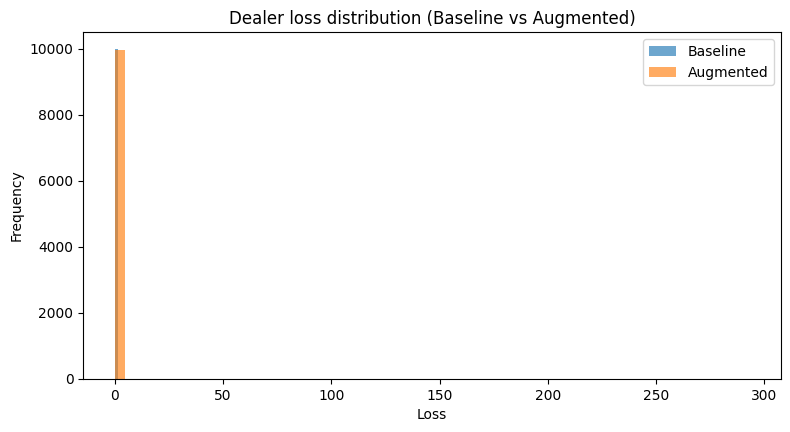

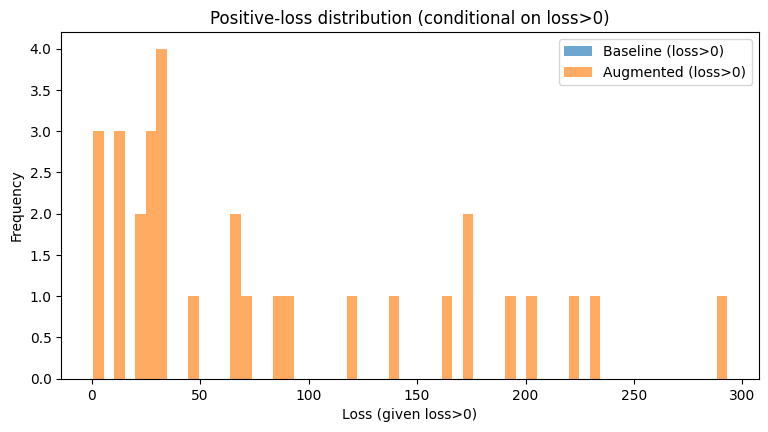

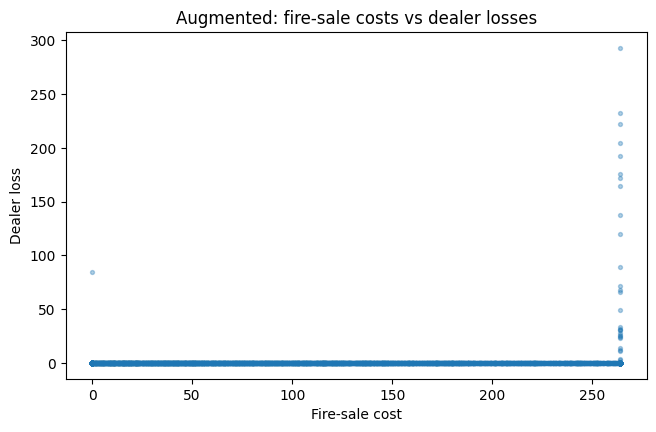

In [11]:
# Distributions (unconditional)
fig, ax = plt.subplots(figsize=(9,4.5))
ax.hist(base_df["loss_B"], bins=60, alpha=0.65, label="Baseline")
ax.hist(aug_df["loss_B"], bins=60, alpha=0.65, label="Augmented")
ax.set_title("Dealer loss distribution (Baseline vs Augmented)")
ax.set_xlabel("Loss")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

# Focus on strictly positive losses (tail shape)
base_pos = base_df.loc[base_df["loss_B"] > 0, "loss_B"].values
aug_pos  = aug_df.loc[aug_df["loss_B"] > 0, "loss_B"].values

fig, ax = plt.subplots(figsize=(9,4.5))
ax.hist(base_pos, bins=60, alpha=0.65, label="Baseline (loss>0)")
ax.hist(aug_pos,  bins=60, alpha=0.65, label="Augmented (loss>0)")
ax.set_title("Positive-loss distribution (conditional on loss>0)")
ax.set_xlabel("Loss (given loss>0)")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

# Fire-sales vs losses
fig, ax = plt.subplots(figsize=(7.5,4.5))
ax.scatter(aug_df["fire_sale_cost"], aug_df["loss_B"], alpha=0.35, s=8)
ax.set_title("Augmented: fire-sale costs vs dealer losses")
ax.set_xlabel("Fire-sale cost")
ax.set_ylabel("Dealer loss")
plt.show()


## 11. Policy Proposals (a–d): Consolidated Comparison (Base vs Augmented)

In [12]:
def scenario_metrics(df: pd.DataFrame, alpha: float = 0.99) -> Dict[str, float]:
    # reuse risk_metrics() from Section 9
    loss = np.asarray(df["loss_B"], dtype=float)
    m = risk_metrics(loss, alpha=alpha)

    out = {
        "P_loss_pos": m["P_loss_pos"],
        "E_loss": m["EL"],
        "VaR_loss": m["VaR"],
        "ES_loss": m["ES"],
        "E_loss_pos": m["EL_pos"],
        "VaR_loss_pos": m["VaR_pos"],
        "ES_loss_pos": m["ES_pos"],
        "max_loss": m["max_loss"],
        "P_default": float(df["default_flag"].mean()),
        "P_liq_default": float((df["default_type"] == "liquidity").mean()) if "default_type" in df.columns else 0.0,
        "E_fire_cost": float(df["fire_sale_cost"].mean()) if "fire_sale_cost" in df.columns else 0.0,
        "E_fire_events": float(df["fire_sale_events"].mean()) if "fire_sale_events" in df.columns else 0.0,
    }
    return out


def run_base_and_aug(
    params0: Dict[str, Any],
    IM: float,
    eligible_share: float | None = None,
    L0_override: float | None = None,
) -> list[dict]:
    """Run baseline + augmented (+ optional expanded collateral) under a given parameter config."""
    L0_use = float(L0_override) if L0_override is not None else float(params0["L0"])

    base = run_baseline_exogenous(
        V=V_paths, IM=IM, MPOR=int(params0["MPOR"]), p_day=p_day, VM_freq=int(params0["VM_freq"]),
        U_exog=U_exog, default_timing=params0["default_timing"], T_sim=int(params0["T_sim"])
    )
    alpha_policy = 0.99
    rows = [{"scenario": "Base", **scenario_metrics(base, alpha=alpha_policy)}]

    aug = run_augmented_liquidity(
        V=V_paths, IM=IM, MPOR=int(params0["MPOR"]), p_day=p_day, VM_freq=int(params0["VM_freq"]),
        L0=L0_use, A0=float(params0["A0"]), h=float(params0["h"]), U_exog=U_exog,
        default_timing=params0["default_timing"], im_posted_from_cash=bool(params0["im_posted_from_cash"]),
        T_sim=int(params0["T_sim"])
    )
    rows.append({"scenario": "Augmented", **scenario_metrics(aug, alpha=alpha_policy)})

    if eligible_share is not None:
        Ill = simulate_illiquid_paths(params0, sigma_factor=1.0)
        aug_coll = run_augmented_collateral_expanded(
            V=V_paths, Ill=Ill, IM=IM, MPOR=int(params0["MPOR"]), p_day=p_day, VM_freq=int(params0["VM_freq"]),
            L0=L0_use, h_sale=float(params0["h"]), eligible_share=float(eligible_share),
            U_exog=U_exog, default_timing=params0["default_timing"],
            im_posted_from_cash=bool(params0["im_posted_from_cash"]), T_sim=int(params0["T_sim"])
        )
        rows.append({"scenario": "Augmented + eligible collateral", **scenario_metrics(aug_coll, alpha=alpha_policy)})

    return rows


# ---- Policy proposals (a–d)
IM0 = float(IM_base)
k_im = 1.4
MPOR_reduced = 6
IM_mpor_reduced, _ = compute_im(Q=params["Q"], sigma_daily=params["sigma_daily"], MPOR=MPOR_reduced, conf=params["IM_conf"], mult=1.0)

# Fixed liquidity budget for IM-funded experiments:
# interpret (L0 + IM0) as the total cash available *before* posting IM.
L_total = float(params["L0"]) + IM0

policy_specs = [
    ("Baseline", {"IM": IM0, "VM_freq": 1, "MPOR": params["MPOR"], "im_posted_from_cash": False}, None, None),

    ("(a) IM increased (net of IM)", {"IM": IM0 * k_im, "VM_freq": 1, "MPOR": params["MPOR"], "im_posted_from_cash": False}, None, None),
    ("(a*) IM increased (IM funded from fixed cash budget)", {"IM": IM0 * k_im, "VM_freq": 1, "MPOR": params["MPOR"], "im_posted_from_cash": True}, None, L_total),

    ("(b) VM weekly (freq=5)", {"IM": IM0, "VM_freq": 5, "MPOR": params["MPOR"], "im_posted_from_cash": False}, None, None),

    (f"(c) MPOR reduced to {MPOR_reduced} (net of IM)", {"IM": IM_mpor_reduced, "VM_freq": 1, "MPOR": MPOR_reduced, "im_posted_from_cash": False}, None, None),
    (f"(c*) MPOR reduced to {MPOR_reduced} (IM funded from fixed cash budget)", {"IM": IM_mpor_reduced, "VM_freq": 1, "MPOR": MPOR_reduced, "im_posted_from_cash": True}, None, L_total),

    ("(d) Expanded collateral (eligible_share=0.75)", {"IM": IM0, "VM_freq": 1, "MPOR": params["MPOR"], "im_posted_from_cash": False}, 0.75, None),
]

rows = []
for label, cfg, eligible_share, L0_override in policy_specs:
    p2 = params.copy()
    p2["VM_freq"] = int(cfg["VM_freq"])
    p2["MPOR"] = int(cfg["MPOR"])
    p2["im_posted_from_cash"] = bool(cfg["im_posted_from_cash"])

    subrows = run_base_and_aug(p2, IM=float(cfg["IM"]), eligible_share=eligible_share, L0_override=L0_override)
    for r in subrows:
        rows.append({"policy": label, **r})

policy_summary = pd.DataFrame(rows)

# Format for easy report insertion (explicit α and probability units)
alpha_policy = 0.99
alpha_tag = int(round(alpha_policy * 100))

fmt = policy_summary.copy()

# Probabilities -> percent (and rename to avoid unit ambiguity)
prob_cols = ["P_loss_pos", "P_default", "P_liq_default"]
for c in prob_cols:
    if c in fmt.columns:
        fmt[c] = (100 * fmt[c]).round(2)

# Round monetary / loss metrics
for c in ["E_loss", "VaR_loss", "ES_loss", "E_loss_pos", "VaR_loss_pos", "ES_loss_pos", "E_fire_cost", "max_loss"]:
    if c in fmt.columns:
        fmt[c] = fmt[c].round(6)
if "E_fire_events" in fmt.columns:
    fmt["E_fire_events"] = fmt["E_fire_events"].round(4)

# Rename VaR/ES columns to make α explicit and mark percent columns
fmt = fmt.rename(columns={
    "P_loss_pos": "P_loss_pos (%)",
    "P_default": "P_default (%)",
    "P_liq_default": "P_liq_default (%)",
    "VaR_loss": f"VaR{alpha_tag}_loss",
    "ES_loss": f"ES{alpha_tag}_loss",
    "VaR_loss_pos": f"VaR{alpha_tag}_loss_pos",
    "ES_loss_pos": f"ES{alpha_tag}_loss_pos",
})

display(fmt.sort_values(["policy", "scenario"]))

print(f"Note: VaR/ES in this table are computed at α={alpha_policy:.2f}. Probability columns are shown in percent.")


,policy,scenario,P_loss_pos (%),E_loss,VaR99_loss,ES99_loss,E_loss_pos,VaR99_loss_pos,ES99_loss_pos,max_loss,P_default (%),P_liq_default (%),E_fire_cost,E_fire_events
3,(a) IM increased (net of IM),Augmented,0.07,0.033215,0.0,0.033215,47.450672,123.492424,127.100359,127.100359,30.52,16.44,100.448185,8.1439
2,(a) IM increased (net of IM),Base,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,15.11,0.00,0.000000,0.0000
5,(a*) IM increased (IM funded from fixed cash b...,Augmented,0.04,0.010670,0.0,0.010670,26.675703,71.522027,72.943916,72.943916,35.77,22.30,125.991378,10.2098
4,(a*) IM increased (IM funded from fixed cash b...,Base,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,15.11,0.00,0.000000,0.0000
7,(b) VM weekly (freq=5),Augmented,0.73,0.644393,0.0,0.644393,88.273002,249.618762,292.913975,292.913975,29.22,15.03,93.803360,3.5009
6,(b) VM weekly (freq=5),Base,0.09,0.046190,0.0,0.046190,51.322366,140.428547,143.139682,143.139682,15.11,0.00,0.000000,0.0000
9,(c) MPOR reduced to 6 (net of IM),Augmented,0.35,0.178038,0.0,0.178038,50.868029,198.047106,199.186508,199.186508,30.52,16.44,100.448185,8.1439
8,(c) MPOR reduced to 6 (net of IM),Base,0.06,0.017324,0.0,0.017324,28.872615,127.399132,132.819862,132.819862,15.11,0.00,0.000000,0.0000
11,(c*) MPOR reduced to 6 (IM funded from fixed c...,Augmented,0.42,0.262006,0.0,0.262006,62.382489,211.773731,219.217817,219.217817,28.87,14.67,92.677162,7.5268
10,(c*) MPOR reduced to 6 (IM funded from fixed c...,Base,0.06,0.017324,0.0,0.017324,28.872615,127.399132,132.819862,132.819862,15.11,0.00,0.000000,0.0000


Note: VaR/ES in this table are computed at α=0.99. Probability columns are shown in percent.


### Section 11 addendum — interpretation of policies (a–d) and a default-timing sensitivity

This block explicitly addresses common interpretation pitfalls:

- why Policy **a** is shown in two variants and which one is economically meaningful,
- why Policy **b** can look counterintuitive in this model (weekly VM),
- why Policy **c** may look “ineffective” under the net-of-IM liquidity convention (and how the IM-funded variant changes that),
- why Policy **d** is a **risk transfer to B** (liquidity relief for A vs higher dealer tail risk),
- and a sensitivity comparing `default_timing = after_vm` vs `before_vm`.


In [13]:

from IPython.display import Markdown

def _pick_row(df: pd.DataFrame, policy_label: str, scenario_label: str) -> pd.Series:
    sel = df[(df["policy"] == policy_label) & (df["scenario"] == scenario_label)]
    if sel.empty:
        raise KeyError(f"Missing row: policy={policy_label}, scenario={scenario_label}")
    return sel.iloc[0]

# Pull key rows (Augmented outcomes are the economically relevant ones for liquidity/fire-sale discussion)
base_aug = _pick_row(fmt, "Baseline", "Augmented")

a_net_aug  = _pick_row(fmt, "(a) IM increased (net of IM)", "Augmented")
a_star_aug = _pick_row(fmt, "(a*) IM increased (IM funded from fixed cash budget)", "Augmented")

b_aug = _pick_row(fmt, "(b) VM weekly (freq=5)", "Augmented")

c_net_label  = f"(c) MPOR reduced to {MPOR_reduced} (net of IM)"
c_star_label = f"(c*) MPOR reduced to {MPOR_reduced} (IM funded from fixed cash budget)"
c_net_aug  = _pick_row(fmt, c_net_label, "Augmented")
c_star_aug = _pick_row(fmt, c_star_label, "Augmented")

d_coll = _pick_row(fmt, "(d) Expanded collateral (eligible_share=0.75)", "Augmented + eligible collateral")

alpha_tag = int(round(0.99 * 100))

note = f"""
#### Policy (a): two variants - which one is economically meaningful?
- **(a) net-of-IM** keeps VM-cash at `L0` by construction (IM is treated as segregated and does not reduce VM liquidity).
  This is best read as a **decomposition**: "what does higher IM do to dealer credit protection, holding VM liquidity constant?"
- **(a*) IM funded from a fixed cash budget** keeps total liquidity `L_total` fixed and deducts IM at `t=0`.
  This is the **economically meaningful** version when discussing liquidity risk / fire-sales.

**Observed (Augmented):**
- P(liquidity default) baseline: **{base_aug['P_liq_default (%)']:.2f}%**
- (a) net-of-IM: **{a_net_aug['P_liq_default (%)']:.2f}%** (unchanged by construction)
- (a*) IM funded: **{a_star_aug['P_liq_default (%)']:.2f}%** (liquidity risk rises because less VM-cash remains)

#### Policy (b): why weekly VM can look counterintuitive in this model
Weekly VM reduces the **frequency** of settlement-induced cash movements. With limited cash and fire-sales, frequent small daily calls can trigger repeated liquidity stress ("churn").
Weekly netting can reduce the **number of times** the liquidity constraint binds, even if each adjustment is larger.

**Observed (Augmented):**
- P(liquidity default): baseline **{base_aug['P_liq_default (%)']:.2f}%** -> weekly VM **{b_aug['P_liq_default (%)']:.2f}%**
- E[fire-sale events]: baseline **{base_aug['E_fire_events']:.4f}** -> weekly VM **{b_aug['E_fire_events']:.4f}**

#### Policy (c): MPOR reduction and the net-of-IM liquidity artefact
MPOR down reduces IM mechanically. Under **net-of-IM** (`im_posted_from_cash=False`), VM-cash remains `L0` irrespective of IM, so **liquidity defaults do not change by construction**.
Under **IM-funded** (`im_posted_from_cash=True`), lower IM frees VM-cash and liquidity defaults can fall.

**Observed (Augmented):**
- (c) net-of-IM P(liquidity default): **{c_net_aug['P_liq_default (%)']:.2f}%** (interpretation: "credit protection changes, VM liquidity held fixed")
- (c*) IM funded P(liquidity default): **{c_star_aug['P_liq_default (%)']:.2f}%** (economically meaningful liquidity effect)

#### Policy (d): expanded collateral is a **risk transfer to B**
Expanded collateral reduces fire-sales/liquidity stress for A, but increases dealer tail risk because collateral value is volatile and may be insufficient at close-out.

**Observed (Augmented):**
- Dealer EL: baseline **{base_aug['E_loss']:.6f}** -> policy (d) **{d_coll['E_loss']:.6f}**
- Dealer ES{alpha_tag}: baseline **{base_aug[f'ES{alpha_tag}_loss']:.6f}** -> policy (d) **{d_coll[f'ES{alpha_tag}_loss']:.6f}**
- A's E[fire-sale cost]: baseline **{base_aug['E_fire_cost']:.6f}** -> policy (d) **{d_coll['E_fire_cost']:.6f}**

---

#### Sensitivity: default timing (`after_vm` vs `before_vm`)
`after_vm` checks exogenous default **after** VM settlement (optimistic). `before_vm` checks default **before** settlement (conservative).
Below we re-run the baseline configuration under both timings.
"""
display(Markdown(note))

# Build sensitivity table
timing_rows = []
for timing in ["after_vm", "before_vm"]:
    p_tmp = params.copy()
    p_tmp["default_timing"] = timing
    sub = run_base_and_aug(p_tmp, IM=float(IM0), eligible_share=None, L0_override=None)
    for r in sub:
        timing_rows.append({"default_timing": timing, **r})

timing_df = pd.DataFrame(timing_rows)

# format similar to policy table (alpha explicit, probs in %)
timing_fmt = timing_df.copy()
for c in ["P_loss_pos", "P_default", "P_liq_default"]:
    if c in timing_fmt.columns:
        timing_fmt[c] = (100 * timing_fmt[c]).round(2)

for c in ["E_loss", "VaR_loss", "ES_loss", "E_loss_pos", "VaR_loss_pos", "ES_loss_pos", "E_fire_cost", "max_loss"]:
    if c in timing_fmt.columns:
        timing_fmt[c] = timing_fmt[c].round(6)
if "E_fire_events" in timing_fmt.columns:
    timing_fmt["E_fire_events"] = timing_fmt["E_fire_events"].round(4)

timing_fmt = timing_fmt.rename(columns={
    "P_loss_pos": "P_loss_pos (%)",
    "P_default": "P_default (%)",
    "P_liq_default": "P_liq_default (%)",
    "VaR_loss": f"VaR{alpha_tag}_loss",
    "ES_loss": f"ES{alpha_tag}_loss",
    "VaR_loss_pos": f"VaR{alpha_tag}_loss_pos",
    "ES_loss_pos": f"ES{alpha_tag}_loss_pos",
})

display(timing_fmt.sort_values(["default_timing", "scenario"]))



#### Policy (a): two variants - which one is economically meaningful?
- **(a) net-of-IM** keeps VM-cash at `L0` by construction (IM is treated as segregated and does not reduce VM liquidity).
  This is best read as a **decomposition**: "what does higher IM do to dealer credit protection, holding VM liquidity constant?"
- **(a*) IM funded from a fixed cash budget** keeps total liquidity `L_total` fixed and deducts IM at `t=0`.
  This is the **economically meaningful** version when discussing liquidity risk / fire-sales.

**Observed (Augmented):**
- P(liquidity default) baseline: **16.44%**
- (a) net-of-IM: **16.44%** (unchanged by construction)
- (a*) IM funded: **22.30%** (liquidity risk rises because less VM-cash remains)

#### Policy (b): why weekly VM can look counterintuitive in this model
Weekly VM reduces the **frequency** of settlement-induced cash movements. With limited cash and fire-sales, frequent small daily calls can trigger repeated liquidity stress ("churn").
Weekly netting can reduce the **number of times** the liquidity constraint binds, even if each adjustment is larger.

**Observed (Augmented):**
- P(liquidity default): baseline **16.44%** -> weekly VM **15.03%**
- E[fire-sale events]: baseline **8.1439** -> weekly VM **3.5009**

#### Policy (c): MPOR reduction and the net-of-IM liquidity artefact
MPOR down reduces IM mechanically. Under **net-of-IM** (`im_posted_from_cash=False`), VM-cash remains `L0` irrespective of IM, so **liquidity defaults do not change by construction**.
Under **IM-funded** (`im_posted_from_cash=True`), lower IM frees VM-cash and liquidity defaults can fall.

**Observed (Augmented):**
- (c) net-of-IM P(liquidity default): **16.44%** (interpretation: "credit protection changes, VM liquidity held fixed")
- (c*) IM funded P(liquidity default): **14.67%** (economically meaningful liquidity effect)

#### Policy (d): expanded collateral is a **risk transfer to B**
Expanded collateral reduces fire-sales/liquidity stress for A, but increases dealer tail risk because collateral value is volatile and may be insufficient at close-out.

**Observed (Augmented):**
- Dealer EL: baseline **0.264181** -> policy (d) **0.276894**
- Dealer ES99: baseline **0.264181** -> policy (d) **0.276894**
- A's E[fire-sale cost]: baseline **100.448185** -> policy (d) **13.568240**

---

#### Sensitivity: default timing (`after_vm` vs `before_vm`)
`after_vm` checks exogenous default **after** VM settlement (optimistic). `before_vm` checks default **before** settlement (conservative).
Below we re-run the baseline configuration under both timings.


,default_timing,scenario,P_loss_pos (%),E_loss,VaR99_loss,ES99_loss,E_loss_pos,VaR99_loss_pos,ES99_loss_pos,max_loss,P_default (%),P_liq_default (%),E_fire_cost,E_fire_events
1,after_vm,Augmented,0.31,0.264181,0.0,0.264181,85.219557,274.874303,292.913975,292.913975,30.52,16.44,100.448185,8.1439
0,after_vm,Base,0.01,0.008488,0.0,0.008488,84.876648,84.876648,84.876648,84.876648,15.11,0.00,0.000000,0.0000
3,before_vm,Augmented,0.34,0.280867,0.0,0.280867,82.607899,273.070336,292.913975,292.913975,30.52,16.44,100.372066,8.1379
2,before_vm,Base,0.04,0.025174,0.0,0.025174,62.934737,140.455991,143.139682,143.139682,15.11,0.00,0.000000,0.0000


## 12. Procyclicality: Stress Runs over Volatility

,sigma_daily,IM,cash_after_IM,EL,VaR99,ES99,P_default (%),P_liq_default (%),E_fire_cost,share_fire_sale (%),max_loss
0,0.300,177.657447,586.876595,0.003638,0.0,0.003638,15.11,0.00,7.416809,13.98,36.375706
1,0.375,222.071808,542.462234,0.004547,0.0,0.004547,15.53,0.44,19.778708,26.36,45.469633
2,0.450,266.486170,498.047872,0.011201,0.0,0.011201,17.09,2.10,36.632639,38.62,54.563559
3,0.525,310.900531,453.633510,0.045202,0.0,0.045202,19.67,4.81,55.870585,48.82,93.657383
4,0.600,355.314893,409.219149,0.090849,0.0,0.090849,23.79,9.27,75.457486,57.62,164.287092
5,0.700,414.534042,350.000000,0.264181,0.0,0.264181,30.52,16.44,100.448185,67.32,292.913975
6,0.800,473.753191,290.780851,0.318722,0.0,0.318722,37.42,24.14,122.894793,75.01,293.601490


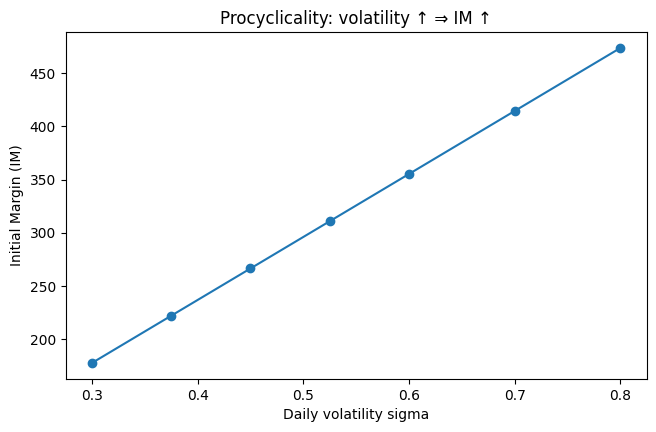

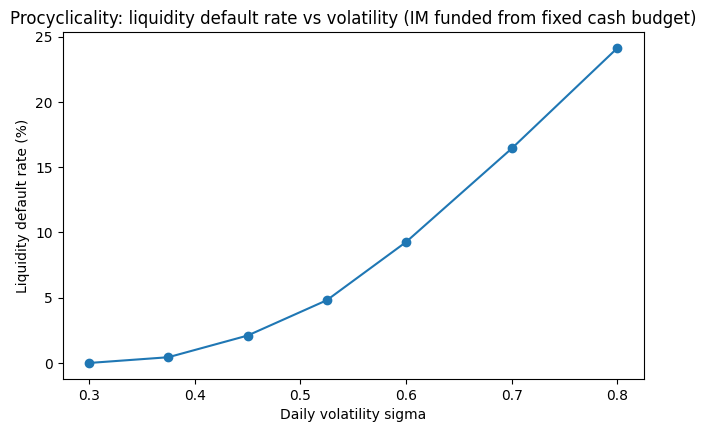

,model,P_default (%),P_liq_default (%),EL,VaR99,ES99,P_loss_pos (%),EL_pos,E_fire_cost,max_loss
0,Fixed haircut h,28.8,15.6,0.345918,0.0,0.345918,0.2,172.959051,97.470847,172.959051
1,Endogenous haircut h_t (systemic),29.0,15.8,0.347249,0.0,0.347249,0.2,173.624558,97.923669,173.624558


Note: VaR/ES in this table are computed at α=0.99. Probability columns are shown in percent.


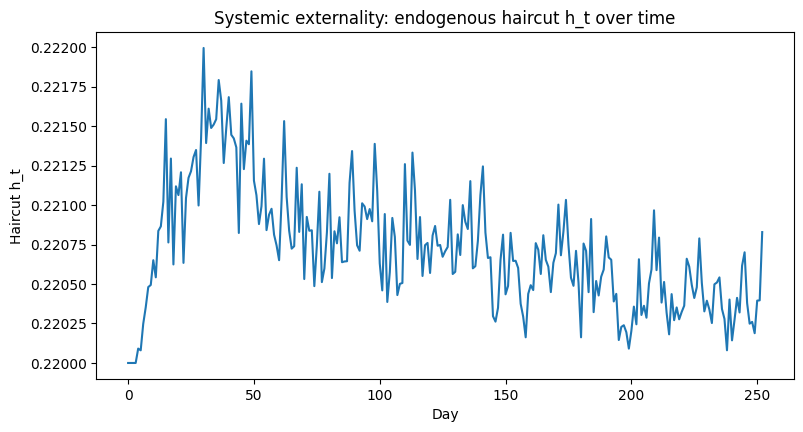

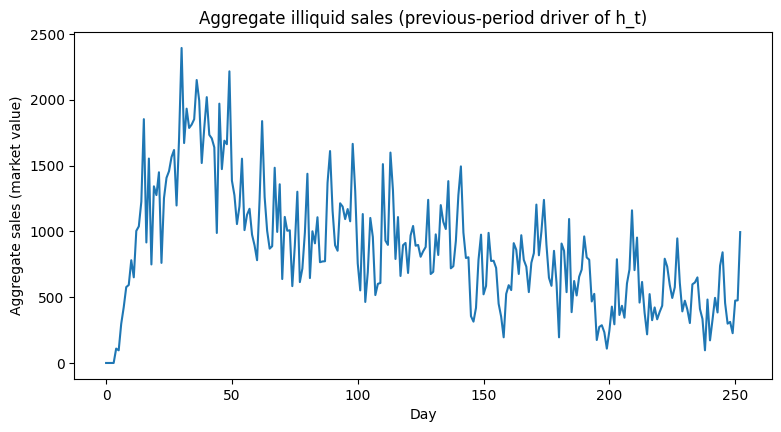

In [14]:
# --- Procyclicality: stress runs over volatility (single-investor model)
# Mechanism: sigma ↑ ⇒ IM ↑ ⇒ (if IM is funded from a fixed cash budget) less cash available for VM ⇒ more liquidity defaults.

sigma_grid = [0.30, 0.375, 0.45, 0.525, 0.60, 0.70, 0.80]
alpha_tail = 0.99

# Fixed liquidity budget (cash before posting IM) — calibrated so that at the baseline IM level,
# the investor still has params["L0"] available as VM cash.
L_total_base = float(params["L0"]) + float(IM_base)

procyc_rows = []
for sigma in sigma_grid:
    p_loc = params.copy()
    p_loc["sigma_daily"] = float(sigma)

    # Market paths
    S_s, V_s = simulate_market_paths(p_loc)
    U_s = generate_exogenous_uniforms(p_loc)

    # Defaults / IM
    p_day_s = annual_pd_to_daily(p_loc["PD_annual"], days=p_loc["T_sim"])
    IM_s, _ = compute_im(Q=p_loc["Q"], sigma_daily=p_loc["sigma_daily"], MPOR=p_loc["MPOR"], conf=p_loc["IM_conf"], mult=p_loc["IM_mult"])

    # IM funded from fixed budget -> cash available after IM is (L_total_base - IM_s)
    aug_s = run_augmented_liquidity(
        V=V_s, IM=IM_s, MPOR=p_loc["MPOR"], p_day=p_day_s, VM_freq=p_loc["VM_freq"],
        L0=L_total_base, A0=p_loc["A0"], h=p_loc["h"], U_exog=U_s,
        default_timing=p_loc["default_timing"], im_posted_from_cash=True, T_sim=p_loc["T_sim"]
    )

    m = scenario_bundle(aug_s, alpha=alpha_tail)

    procyc_rows.append({
        "sigma_daily": sigma,
        "IM": float(IM_s),
        "cash_after_IM": float(L_total_base - IM_s),
        "EL": m["EL"],
        "VaR": m["VaR"],
        "ES": m["ES"],
        "P_default": float(aug_s["default_flag"].mean()),
        "P_liq_default": float((aug_s["default_type"] == "liquidity").mean()),
        "E_fire_cost": float(aug_s["fire_sale_cost"].mean()),
        "share_fire_sale": float(np.mean(aug_s["fire_sale_events"] > 0)),
        "max_loss": m["max_loss"],
    })

procyc_df = pd.DataFrame(procyc_rows)
# Report-friendly view (explicit α and probability units)
alpha_tag = int(round(alpha_tail * 100))
procyc_view = procyc_df.copy()

for c in ["P_default", "P_liq_default", "share_fire_sale"]:
    if c in procyc_view.columns:
        procyc_view[c] = (100 * procyc_view[c]).round(2)

for c in ["IM", "EL", "VaR", "ES", "E_fire_cost", "max_loss"]:
    if c in procyc_view.columns:
        procyc_view[c] = procyc_view[c].round(6)

procyc_view = procyc_view.rename(columns={
    "P_default": "P_default (%)",
    "P_liq_default": "P_liq_default (%)",
    "share_fire_sale": "share_fire_sale (%)",
    "VaR": f"VaR{alpha_tag}",
    "ES": f"ES{alpha_tag}",
})

display(procyc_view)

fig, ax = plt.subplots(figsize=(7.5,4.5))
ax.plot(procyc_df["sigma_daily"], procyc_df["IM"], marker="o")
ax.set_title("Procyclicality: volatility ↑ ⇒ IM ↑")
ax.set_xlabel("Daily volatility sigma")
ax.set_ylabel("Initial Margin (IM)")
plt.show()

fig, ax = plt.subplots(figsize=(7.5,4.5))
ax.plot(procyc_df["sigma_daily"], 100*procyc_df["P_liq_default"], marker="o")
ax.set_title("Procyclicality: liquidity default rate vs volatility (IM funded from fixed cash budget)")
ax.set_xlabel("Daily volatility sigma")
ax.set_ylabel("Liquidity default rate (%)")
plt.show()

# --- Section 1.5: Systemic liquidity externality (endogenous haircut h_t)
# Requirement: the fire-sale discount h_t increases with aggregate sales of illiquid assets in the previous period.

def run_augmented_liquidity_endogenous_h(
    V: np.ndarray,
    IM: float,
    MPOR: int,
    p_day: float,
    VM_freq: int,
    L_total: float,
    A0: float,
    h0: float,
    h_max: float,
    gamma_h: float,
    U_exog: np.ndarray,
    default_timing: Literal["before_vm", "after_vm"] = "after_vm",
    T_sim: int = 252,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Multi-investor simulation with endogenous haircut.

    - Common haircut h_t applied to all fire-sales on day t
    - h_{t+1} = clip(h0 + gamma_h * (AggSales_t / (M*A0)), [h0, h_max])
    """
    M = V.shape[0]
    cash = np.full(M, float(L_total) - float(IM), dtype=float)  # cash after posting IM
    illiq = np.full(M, float(A0), dtype=float)

    vm_bal = np.zeros(M, dtype=float)
    required_prev = np.zeros(M, dtype=float)

    defaulted = np.zeros(M, dtype=bool)
    default_type = np.full(M, "none", dtype=object)
    default_day = np.full(M, -1, dtype=int)
    last_VM_posted = np.zeros(M, dtype=float)

    fire_sale_cost = np.zeros(M, dtype=float)
    fire_sale_events = np.zeros(M, dtype=int)

    # Time series tracking
    h_series = np.zeros(T_sim + 1, dtype=float)
    sales_series = np.zeros(T_sim + 1, dtype=float)

    h_t = float(h0)
    h_series[0] = h_t

    for t in range(1, int(T_sim) + 1):
        sales_today = 0.0

        # Exogenous default before VM
        if default_timing == "before_vm":
            ex = (~defaulted) & (U_exog[:, t - 1] < float(p_day))
            if np.any(ex):
                defaulted[ex] = True
                default_type[ex] = "exogenous"
                default_day[ex] = t
                last_VM_posted[ex] = vm_bal[ex]

        # VM settlement
        if (t % int(VM_freq)) == 0:
            required = np.maximum(0.0, -V[:, t])
            margin_call = required - required_prev

            alive = ~defaulted
            # iterate only alive investors (keeps logic simple and matches single-investor engine)
            idxs = np.where(alive)[0]
            for i in idxs:
                mc = float(margin_call[i])

                if mc > 0:
                    need = mc

                    pay = min(float(cash[i]), need)
                    cash[i] -= pay
                    vm_bal[i] += pay
                    need -= pay

                    if need > 1e-12 and illiq[i] > 0:
                        sell_mv = min(float(illiq[i]), need / (1.0 - h_t))
                        proceeds = sell_mv * (1.0 - h_t)
                        illiq[i] -= sell_mv
                        cash[i] += proceeds

                        if sell_mv > 0:
                            fire_sale_cost[i] += sell_mv * h_t
                            fire_sale_events[i] += 1
                            sales_today += sell_mv

                        pay2 = min(float(cash[i]), need)
                        cash[i] -= pay2
                        vm_bal[i] += pay2
                        need -= pay2

                    if need > 1e-6:
                        defaulted[i] = True
                        default_type[i] = "liquidity"
                        default_day[i] = t
                        last_VM_posted[i] = vm_bal[i]
                        continue

                elif mc < 0:
                    release = -mc
                    vm_bal[i] = float(required[i])
                    cash[i] += release

                vm_bal[i] = float(required[i])
                required_prev[i] = float(required[i])
                last_VM_posted[i] = vm_bal[i]

        # Exogenous default after VM
        if default_timing == "after_vm":
            ex = (~defaulted) & (U_exog[:, t - 1] < float(p_day))
            if np.any(ex):
                defaulted[ex] = True
                default_type[ex] = "exogenous"
                default_day[ex] = t
                last_VM_posted[ex] = vm_bal[ex]

        # Update haircut for next day based on aggregate sales today
        sales_series[t] = float(sales_today)
        sale_share = float(sales_today) / (float(M) * float(A0) + 1e-12)
        h_t = min(float(h_max), max(float(h0), float(h0) + float(gamma_h) * sale_share))
        h_series[t] = h_t

    # Losses to B at default (same loss definition as single-investor augmented model)
    losses = np.zeros(M, dtype=float)
    for i in range(M):
        if defaulted[i]:
            t_def = int(default_day[i])
            close_t = t_def + int(MPOR)
            owed = max(-float(V[i, close_t]), 0.0)
            collateral_available = float(IM) + max(float(last_VM_posted[i]), 0.0)
            losses[i] = max(owed - collateral_available, 0.0)

    df = pd.DataFrame({
        "loss_B": losses,
        "default_flag": defaulted,
        "default_type": default_type,
        "default_day": default_day,
        "fire_sale_cost": fire_sale_cost,
        "fire_sale_events": fire_sale_events,
        "last_VM_posted": last_VM_posted,
        "cash_end": cash,
        "illiquid_end": illiq,
    })

    ts = pd.DataFrame({
        "day": np.arange(T_sim + 1, dtype=int),
        "h": h_series,
        "agg_sales": sales_series,
    })
    return df, ts


# Run one illustrative systemic experiment (baseline sigma), then compare to fixed-h control
p_sys = params.copy()
p_sys["N"] = int(params["systemic_M"])  # reuse N for the systemic experiment
p_sys["sigma_daily"] = float(params["sigma_daily"])
p_sys["seed"] = int(params["seed"]) + 999

S_sys, V_sys = simulate_market_paths(p_sys)
U_sys = generate_exogenous_uniforms(p_sys)
p_day_sys = annual_pd_to_daily(p_sys["PD_annual"], days=p_sys["T_sim"])
IM_sys, _ = compute_im(Q=p_sys["Q"], sigma_daily=p_sys["sigma_daily"], MPOR=p_sys["MPOR"], conf=p_sys["IM_conf"], mult=p_sys["IM_mult"])

# Constant-h benchmark (same market paths, same uniforms)
aug_fixed = run_augmented_liquidity(
    V=V_sys, IM=IM_sys, MPOR=p_sys["MPOR"], p_day=p_day_sys, VM_freq=p_sys["VM_freq"],
    L0=L_total_base, A0=p_sys["A0"], h=p_sys["h"], U_exog=U_sys,
    default_timing=p_sys["default_timing"], im_posted_from_cash=True, T_sim=p_sys["T_sim"]
)

# Endogenous-h systemic run (haircut responds to aggregate sales)
aug_endog, ts_endog = run_augmented_liquidity_endogenous_h(
    V=V_sys, IM=IM_sys, MPOR=p_sys["MPOR"], p_day=p_day_sys, VM_freq=p_sys["VM_freq"],
    L_total=L_total_base, A0=p_sys["A0"], h0=p_sys["h"],
    h_max=p_sys["h_max"], gamma_h=p_sys["gamma_h"],
    U_exog=U_sys, default_timing=p_sys["default_timing"], T_sim=p_sys["T_sim"]
)

m_fixed = scenario_bundle(aug_fixed, alpha=alpha_tail)
m_endog = scenario_bundle(aug_endog, alpha=alpha_tail)

sys_compare = pd.DataFrame([
    {"model": "Fixed haircut h", **{k: m_fixed[k] for k in ["P_default","P_liq_default","EL","VaR","ES","P_loss_pos","EL_pos","E_fire_cost","max_loss"]}},
    {"model": "Endogenous haircut h_t (systemic)", **{k: m_endog[k] for k in ["P_default","P_liq_default","EL","VaR","ES","P_loss_pos","EL_pos","E_fire_cost","max_loss"]}},
])
# Report-friendly view (explicit α and probability units)
alpha_tag = int(round(alpha_tail * 100))
sys_compare_view = sys_compare.copy()

for c in ["P_default", "P_liq_default", "P_loss_pos"]:
    if c in sys_compare_view.columns:
        sys_compare_view[c] = (100 * sys_compare_view[c]).round(2)

for c in ["EL", "VaR", "ES", "EL_pos", "E_fire_cost", "max_loss"]:
    if c in sys_compare_view.columns:
        sys_compare_view[c] = sys_compare_view[c].round(6)

sys_compare_view = sys_compare_view.rename(columns={
    "P_default": "P_default (%)",
    "P_liq_default": "P_liq_default (%)",
    "P_loss_pos": "P_loss_pos (%)",
    "VaR": f"VaR{alpha_tag}",
    "ES": f"ES{alpha_tag}",
})

display(sys_compare_view)

print(f"Note: VaR/ES in this table are computed at α={alpha_tail:.2f}. Probability columns are shown in percent.")

fig, ax = plt.subplots(figsize=(9,4.5))
ax.plot(ts_endog["day"], ts_endog["h"])
ax.set_title("Systemic externality: endogenous haircut h_t over time")
ax.set_xlabel("Day")
ax.set_ylabel("Haircut h_t")
plt.show()

fig, ax = plt.subplots(figsize=(9,4.5))
ax.plot(ts_endog["day"], ts_endog["agg_sales"])
ax.set_title("Aggregate illiquid sales (previous-period driver of h_t)")
ax.set_xlabel("Day")
ax.set_ylabel("Aggregate sales (market value)")
plt.show()


## 13. Final Summary (Report-Style Answers to the Assignment)

In [15]:
def pct(x: float) -> str:
    return f"{100*float(x):.2f}%"


def f6(x: float) -> str:
    return f"{float(x):.6f}"


def pick(d: Dict[str, float], k: str, default: float = 0.0) -> float:
    return float(d.get(k, default))


b = metrics_base_99
a = metrics_aug_99

report = f"""### Task 2a — Initial Margin (IM) Derivation
Assuming additive normal price changes over MPOR:

- Price change over MPOR: ΔS ~ Normal(0, MPOR * sigma_daily²)
- Forward MTM: V = Q (S - K)  ⇒  ΔV ~ Normal(0, (|Q| * sigma_daily * sqrt(MPOR))²)

One-sided VaR-based IM over MPOR:
`IM = z_conf * |Q| * sigma_daily * sqrt(MPOR)`

with `z_conf = {z_conf:.6f}` and **baseline IM = {IM_base:.6f}**.

---

### Task 2b — Simulation
We simulate **N = {params['N']}** paths over **T_sim = {params['T_sim']}** days and extend paths to **T_sim + MPOR** to evaluate close-out at `t_def + MPOR`.

---

### Task 2c — Defaults (Baseline vs Augmented)
Annual exogenous PD = {params['PD_annual']} ⇒ daily `p_day = {p_day:.8f}`, checked **{params['default_timing']}** VM settlement.

VM mechanics are **symmetric** on margin-call dates `t`:
- `VM_A_to_B(t) = max(0, -V_t)` (A posts if A is out-of-the-money)
- `VM_B_to_A(t) = max(0,  V_t)` (B posts if B is out-of-the-money)
Party **B is always liquid** (can always post/return VM); party **A** may be liquidity-constrained in the augmented setting.

Liquidity convention used in the augmented setting:
- Default case `im_posted_from_cash=False`: `L0` denotes VM-cash **net of** baseline IM (IM is treated as segregated/posted at t=0).
- For IM-changing policies we also report an IM-funded variant (`im_posted_from_cash=True`) holding total liquidity `L_total = L0 + IM_base` fixed.


- **Baseline (unlimited cash for VM):**  
  P(default) = **{pct(pick(b,'P_default'))}**, P(loss>0) = **{pct(pick(b,'P_loss_pos'))}**

- **Augmented (liquidity constraints + fire-sales):**  
  P(default) = **{pct(pick(a,'P_default'))}**  
  P(liquidity-default) = **{pct(pick(a,'P_liq_default'))}**  
  E[fire-sale cost] = **{f6(pick(a,'E_fire_cost'))}**

---

### Task 2d — Loss Distribution to Dealer B (mass at zero + conditional tail)
Loss definition used in the code:
`Loss_B = max( max(-V[t_def+MPOR], 0) - (IM + max(VM[t_def], 0)), 0 )`

Because many paths have **no default and/or sufficient collateral**, the loss distribution has a large point mass at 0, so **unconditional VaR(99%) can be 0**. Formally, if `P(Loss = 0) >= 99%`, then `VaR99 = 0` by definition. Therefore we report both unconditional metrics and *tail* metrics conditional on `Loss > 0`:

- **Baseline:**  
  EL = {f6(pick(b,'EL'))}, VaR99 = {f6(pick(b,'VaR'))}, ES99 = {f6(pick(b,'ES'))}  
  Conditional on loss>0: EL_pos = {f6(pick(b,'EL_pos'))}, VaR99_pos = {f6(pick(b,'VaR_pos'))}, ES99_pos = {f6(pick(b,'ES_pos'))}

- **Augmented:**  
  EL = {f6(pick(a,'EL'))}, VaR99 = {f6(pick(a,'VaR'))}, ES99 = {f6(pick(a,'ES'))}  
  Conditional on loss>0: EL_pos = {f6(pick(a,'EL_pos'))}, VaR99_pos = {f6(pick(a,'VaR_pos'))}, ES99_pos = {f6(pick(a,'ES_pos'))}

Also (Augmented) conditional on default:  
EL|default = {f6(pick(a,'EL_given_default'))}, P(loss>0 | default) = {pct(pick(a,'P_loss_pos_given_default'))}, EL_pos|default = {f6(pick(a,'EL_pos_given_default'))}

---

### Policy proposals (a–d) — headline interpretation
Policy effects are summarized in Section 11 (`policy_summary`) plus the **Section 11 addendum** (explicit interpretations).

Key points:
- (a) IM is shown in two variants: **net-of-IM** (pure protection effect) vs **IM funded from a fixed cash budget** (economically meaningful for liquidity).
- (b) Weekly VM can reduce liquidity stress in this model because it reduces **settlement churn**; see addendum for the mechanism and numbers.
- (c) MPOR↓ reduces IM mechanically; under net-of-IM it may not change liquidity **by construction**, so we also report an IM-funded variant (c*).
- (d) Expanded collateral reduces fire-sales/liquidity stress for A but increases dealer tail risk — explicit **risk transfer to B** (see addendum with EL/ES and fire-sale numbers).

---

### Procyclicality (Section 1.5) — implemented
1) **Margin procyclicality (single investor):** sigma ↑ ⇒ IM ↑ ⇒ cash-after-IM ↓ (fixed cash budget) ⇒ liquidity defaults ↑.  
2) **Systemic liquidity externality:** endogenous haircut updated by aggregate sales from the previous period:  
`h_next = clip(h0 + gamma * AggSales_t/(M*A0), [h0, h_max])`  
Comparison fixed-h vs endogenous-h is shown in `sys_compare` + plots of h_t and aggregate sales.
"""

display(Markdown(report))


### Task 2a — Initial Margin (IM) Derivation
Assuming additive normal price changes over MPOR:

- Price change over MPOR: ΔS ~ Normal(0, MPOR * sigma_daily²)
- Forward MTM: V = Q (S - K)  ⇒  ΔV ~ Normal(0, (|Q| * sigma_daily * sqrt(MPOR))²)

One-sided VaR-based IM over MPOR:
`IM = z_conf * |Q| * sigma_daily * sqrt(MPOR)`

with `z_conf = 2.326348` and **baseline IM = 414.534042**.

---

### Task 2b — Simulation
We simulate **N = 10000** paths over **T_sim = 252** days and extend paths to **T_sim + MPOR** to evaluate close-out at `t_def + MPOR`.

---

### Task 2c — Defaults (Baseline vs Augmented)
Annual exogenous PD = 0.15 ⇒ daily `p_day = 0.00064471`, checked **after_vm** VM settlement.

VM mechanics are **symmetric** on margin-call dates `t`:
- `VM_A_to_B(t) = max(0, -V_t)` (A posts if A is out-of-the-money)
- `VM_B_to_A(t) = max(0,  V_t)` (B posts if B is out-of-the-money)
Party **B is always liquid** (can always post/return VM); party **A** may be liquidity-constrained in the augmented setting.

Liquidity convention used in the augmented setting:
- Default case `im_posted_from_cash=False`: `L0` denotes VM-cash **net of** baseline IM (IM is treated as segregated/posted at t=0).
- For IM-changing policies we also report an IM-funded variant (`im_posted_from_cash=True`) holding total liquidity `L_total = L0 + IM_base` fixed.


- **Baseline (unlimited cash for VM):**  
  P(default) = **15.11%**, P(loss>0) = **0.01%**

- **Augmented (liquidity constraints + fire-sales):**  
  P(default) = **30.52%**  
  P(liquidity-default) = **16.44%**  
  E[fire-sale cost] = **100.448185**

---

### Task 2d — Loss Distribution to Dealer B (mass at zero + conditional tail)
Loss definition used in the code:
`Loss_B = max( max(-V[t_def+MPOR], 0) - (IM + max(VM[t_def], 0)), 0 )`

Because many paths have **no default and/or sufficient collateral**, the loss distribution has a large point mass at 0, so **unconditional VaR(99%) can be 0**. Formally, if `P(Loss = 0) >= 99%`, then `VaR99 = 0` by definition. Therefore we report both unconditional metrics and *tail* metrics conditional on `Loss > 0`:

- **Baseline:**  
  EL = 0.008488, VaR99 = 0.000000, ES99 = 0.008488  
  Conditional on loss>0: EL_pos = 84.876648, VaR99_pos = 84.876648, ES99_pos = 84.876648

- **Augmented:**  
  EL = 0.264181, VaR99 = 0.000000, ES99 = 0.264181  
  Conditional on loss>0: EL_pos = 85.219557, VaR99_pos = 274.874303, ES99_pos = 292.913975

Also (Augmented) conditional on default:  
EL|default = 0.865598, P(loss>0 | default) = 1.02%, EL_pos|default = 85.219557

---

### Policy proposals (a–d) — headline interpretation
Policy effects are summarized in Section 11 (`policy_summary`) plus the **Section 11 addendum** (explicit interpretations).

Key points:
- (a) IM is shown in two variants: **net-of-IM** (pure protection effect) vs **IM funded from a fixed cash budget** (economically meaningful for liquidity).
- (b) Weekly VM can reduce liquidity stress in this model because it reduces **settlement churn**; see addendum for the mechanism and numbers.
- (c) MPOR↓ reduces IM mechanically; under net-of-IM it may not change liquidity **by construction**, so we also report an IM-funded variant (c*).
- (d) Expanded collateral reduces fire-sales/liquidity stress for A but increases dealer tail risk — explicit **risk transfer to B** (see addendum with EL/ES and fire-sale numbers).

---

### Procyclicality (Section 1.5) — implemented
1) **Margin procyclicality (single investor):** sigma ↑ ⇒ IM ↑ ⇒ cash-after-IM ↓ (fixed cash budget) ⇒ liquidity defaults ↑.  
2) **Systemic liquidity externality:** endogenous haircut updated by aggregate sales from the previous period:  
`h_next = clip(h0 + gamma * AggSales_t/(M*A0), [h0, h_max])`  
Comparison fixed-h vs endogenous-h is shown in `sys_compare` + plots of h_t and aggregate sales.


## 14. Critical Sanity Checks (Realism & Assignment Coverage)
This section stress-tests whether the produced magnitudes and comparative statics are economically plausible and whether outputs map to the assignment questions.

In [16]:
# --- Quick realism checks + "does it answer the assignment?" checks

checks = []

# 1) IM magnitude sanity check (back-of-envelope)
sigma = float(params["sigma_daily"])
MPOR = int(params["MPOR"])
Q = float(params["Q"])
z = float(z_conf)

sigma_mpor = sigma * np.sqrt(MPOR)
sd_dV = abs(Q) * sigma_mpor
im_approx = z * sd_dV * float(params["IM_mult"])

checks.append({
    "Check": "IM formula back-of-envelope (z*|Q|*sigma*sqrt(MPOR)) matches computed IM_base",
    "Expected": f"approx {im_approx:.3f}",
    "Observed": f"{IM_base:.3f}",
    "PASS": abs(im_approx - float(IM_base)) < 1e-6
})

# 2) Exogenous default probability sanity check (baseline should be close to PD_annual over 252 days)
p_no = (1.0 - p_day) ** int(params["T_sim"])
p_def_theory = 1.0 - p_no

p_def_sim = float(base_df["default_flag"].mean())

p_def_theory_pct = 100.0 * p_def_theory
p_def_sim_pct = 100.0 * p_def_sim

checks.append({
    "Check": "Baseline exogenous default rate ≈ theoretical PD over T_sim",
    "Expected": f"{p_def_theory_pct:.1f}%",
    "Observed": f"{p_def_sim_pct:.1f}%",
    "PASS": abs(p_def_sim_pct - p_def_theory_pct) < 2.0  # MC tolerance in %-points
})

# 3) Augmented should weakly increase default probability (liquidity adds another channel)
p_def_aug = float(aug_df["default_flag"].mean())
checks.append({
    "Check": "Augmented default rate ≥ baseline default rate (liquidity adds an extra default channel)",
    "Expected": "≥ baseline",
    "Observed": f"{100*p_def_aug:.1f}% vs {100*p_def_sim:.1f}%",
    "PASS": p_def_aug >= p_def_sim - 1e-6
})

# 4) Positive-loss tail should exist (conditional metrics non-trivial)
checks.append({
    "Check": "Conditional VaR99 on loss>0 is > 0 (otherwise tail reporting is degenerate)",
    "Expected": "> 0",
    "Observed": f"{metrics_aug_99['VaR_pos']:.6f}",
    "PASS": float(metrics_aug_99["VaR_pos"]) > 0.0
})

# 5) Fire-sales should be economically active in augmented model
checks.append({
    "Check": "Augmented E[fire-sale cost] > 0 (fire-sale channel active)",
    "Expected": "> 0",
    "Observed": f"{metrics_aug_99['E_fire_cost']:.6f}",
    "PASS": float(metrics_aug_99["E_fire_cost"]) > 0.0
})

# 6) Policy (a*) should show the intended trade-off: higher IM funded from fixed budget ⇒ liquidity risk ↑ (typical)
try:
    pol = policy_summary.copy()
    base_aug = pol[(pol["policy"]=="Baseline") & (pol["scenario"]=="Augmented")].iloc[0]
    aimf_aug = pol[(pol["policy"].str.contains(r"\(a\*\)")) & (pol["scenario"]=="Augmented")].iloc[0]

    checks.append({
        "Check": "Policy (a*) (IM funded): P(liquidity default) higher than Baseline (Augmented)",
        "Expected": "↑",
        "Observed": f"{100*aimf_aug['P_liq_default']:.2f}% vs {100*base_aug['P_liq_default']:.2f}%",
        "PASS": float(aimf_aug["P_liq_default"]) >= float(base_aug["P_liq_default"]) - 1e-6
    })
except Exception as e:
    checks.append({
        "Check": "Policy (a*) trade-off row exists in policy_summary",
        "Expected": "row present",
        "Observed": f"error: {e}",
        "PASS": False
    })

# 7) Section 1.5 systemic externality: endogenous haircut should vary over time (otherwise coupling is inert)
try:
    h_var = float(ts_endog["h"].var())
    checks.append({
        "Check": "Systemic procyclicality: endogenous haircut h_t varies over time",
        "Expected": "variance > 0",
        "Observed": f"var={h_var:.8f}",
        "PASS": h_var > 0.0
    })
except Exception as e:
    checks.append({
        "Check": "Systemic procyclicality objects (ts_endog) exist",
        "Expected": "exists",
        "Observed": f"error: {e}",
        "PASS": False
    })

check_df = pd.DataFrame(checks)
display(check_df)

# A concise interpretation prompt for the report
n_fail = int((~check_df["PASS"]).sum())
print(f"Sanity checks: {len(check_df)-n_fail}/{len(check_df)} PASS. Fails (if any) require report discussion or parameter adjustment.")


,Check,Expected,Observed,PASS
0,IM formula back-of-envelope (z*|Q|*sigma*sqrt(...,approx 414.534,414.534,True
1,Baseline exogenous default rate ≈ theoretical ...,15.0%,15.1%,True
2,Augmented default rate ≥ baseline default rate...,≥ baseline,30.5% vs 15.1%,True
3,Conditional VaR99 on loss>0 is > 0 (otherwise ...,> 0,274.874303,True
4,Augmented E[fire-sale cost] > 0 (fire-sale cha...,> 0,100.448185,True
5,Policy (a*) (IM funded): P(liquidity default) ...,↑,22.30% vs 16.44%,True
6,Systemic procyclicality: endogenous haircut h_...,variance > 0,var=0.00000015,True


Sanity checks: 7/7 PASS. Fails (if any) require report discussion or parameter adjustment.
